# Imports

In [1]:
import numpy as np
import time
import pyscf
from pyscf import dft, scf
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from pyscf import gto, lo, tools, dft 
import pyscf.mp
import pyscf.ci
import py3Dmol
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 1. SMILES strings

## (a)

COc1cc(C=O)ccc1O

## (b)

Since nodes appear in the string in the order that they are visited by DFS, e.g. a 
different root node will produce a different order, and thus a different string.

# 2. PySCF calculations
## (a)

In [2]:
smiles = 'COc1cc(C=O)ccc1O'
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

In [3]:
def show(mol):
    style = 'stick'
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=1000)
    mblock = Chem.MolToMolBlock(mol)
    view = py3Dmol.view(width=200, height=200)
    view.addModel(mblock, 'mol')
    view.setStyle({style:{}})
    view.zoomTo()
    view.show()
show(mol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:
def m2m(mol):
    elements = [atom.GetSymbol() for atom in mol.GetAtoms()]
    coordinates = mol.GetConformer().GetPositions()
    atoms = [(element, coordinate) for element, coordinate in zip(elements, coordinates)]
    
    pyscf_mole = gto.Mole()
    pyscf_mole.atom = atoms
    pyscf_mole.build()

    return pyscf_mole

def rks(mol):    
    mf = dft.RKS(mol)
    mf.run();

In [5]:
rks(m2m(mol))

converged SCF energy = -523.934184341745


## (b)

In [6]:
def make_water(n=3):
    # Function to create a single water molecule
    def h2o():
        mol = Chem.MolFromSmiles('O')
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        return mol
    
    # Create a new empty editable molecule
    water = Chem.RWMol()
    
    # Initialize positions
    x_offset = 100.0  # angstroms
    current_position = 0.0
    
    # Create and position 10 water molecules
    for i in range(n):
        single = h2o()
        conf = single.GetConformer()
        for atom_idx in range(single.GetNumAtoms()):
            pos = conf.GetAtomPosition(atom_idx)
            conf.SetAtomPosition(atom_idx, Chem.rdGeometry.Point3D(pos.x + current_position, pos.y, pos.z))
        water.InsertMol(single)
        current_position += x_offset

    return water

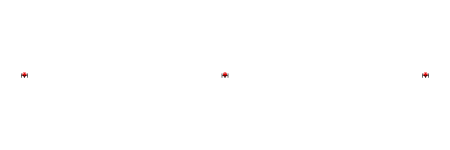

In [7]:
make_water(3)

In [8]:
# do as many as we can until the time runs out
def make_stats(f, maxiter, maxtime_sec):
    loop_start = time.time()
    times = []
    sizes = []
    for i in range(1,maxiter):
        if time.time() - loop_start > maxtime_sec:
            print('tl exceeded')
            break
        mol = make_water(i)
        start = time.time()
    
        f(m2m(mol))
        times.append(time.time() - loop_start)
        sizes.append(i)
    return times, sizes

In [9]:
times, sizes = make_stats(rks, 50, 300)

converged SCF energy = -74.733849459309
converged SCF energy = -149.464891397766
converged SCF energy = -224.203666694875
converged SCF energy = -298.939286536943
converged SCF energy = -373.681327474522
converged SCF energy = -448.408101985058
converged SCF energy = -523.14467951872
converged SCF energy = -597.881454292322
converged SCF energy = -672.616646759054
converged SCF energy = -747.346001449401
converged SCF energy = -822.092950283583
converged SCF energy = -896.797965967827
converged SCF energy = -971.555974201536
converged SCF energy = -1046.25772331709
converged SCF energy = -1121.03400811523
converged SCF energy = -1195.76244328615
converged SCF energy = -1270.48895200062
converged SCF energy = -1345.22915069711
converged SCF energy = -1419.98590433938
converged SCF energy = -1494.69602048063
converged SCF energy = -1569.4315970825
converged SCF energy = -1644.1716839882
converged SCF energy = -1718.896525912
converged SCF energy = -1793.62961428427
converged SCF energy =

In [10]:
def plot_comp(sizes, times, method, loglog=True):
    def exp(x, a, b): return a * (x ** b)
    p, cov = curve_fit(exp, sizes, times)
    plt.plot(sizes, times, label='data')
    plt.plot(sizes, [exp(i, *p) for i in sizes], label='fit')
    title = f'estimated {method} time complexity: {p[0]:.2f}*n^{p[1]:.2f}'
    plt.title(title)
    if loglog:
        plt.gca().set_yscale('log')
        plt.gca().set_xscale('log')
        plt.title(title + ' (log-log)')
    plt.xlabel('number of water molecules')
    plt.ylabel('time')
    plt.legend()
    plt.show()

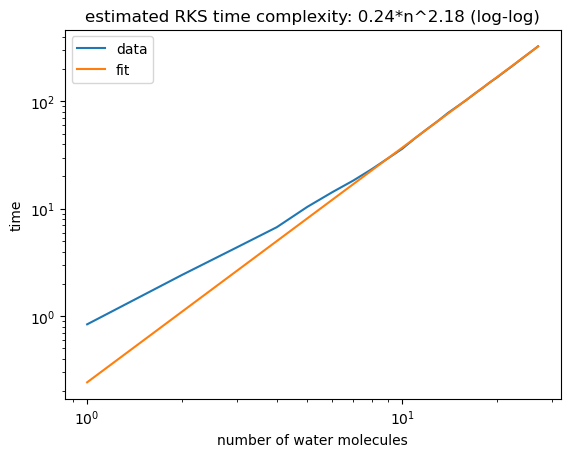

In [11]:
plot_comp(sizes, times, 'RKS')

## (c)

In [12]:
def cisd(mol):
    hf = scf.RHF(mol)
    hf.run()
    # CISD calculation
    pyscf.ci.CISD(hf).run()
    
def mp2(mol):
    hf = scf.RHF(mol)
    hf.run()
    # MP2 calculation
    pyscf.mp.MP2(hf).run()

converged SCF energy = -74.9642448200938
E(RCISD) = -75.01655553664902  E_corr = -0.05231071655523459
converged SCF energy = -149.918033954898
E(RCISD) = -150.0189392654599  E_corr = -0.1009053105622607
converged SCF energy = -224.883287087856
E(RCISD) = -225.030194046034  E_corr = -0.1469069581780424
converged SCF energy = -299.853149957516
E(RCISD) = -300.0479705094374  E_corr = -0.1948205519217048
converged SCF energy = -374.812677454929
E(RCISD) = -375.0503256242947  E_corr = -0.2376481693657484
converged SCF energy = -449.771929611766
E(RCISD) = -450.0516232382989  E_corr = -0.279693626532994
converged SCF energy = -524.738081152501
E(RCISD) = -525.0566829558032  E_corr = -0.3186018033021329
converged SCF energy = -599.698586351008
E(RCISD) = -600.0545905883217  E_corr = -0.3560042373133571
converged SCF energy = -674.657929677064
E(RCISD) = -675.0511372853159  E_corr = -0.393207608251973
converged SCF energy = -749.619761795058
E(RCISD) = -750.0515662173166  E_corr = -0.431804422

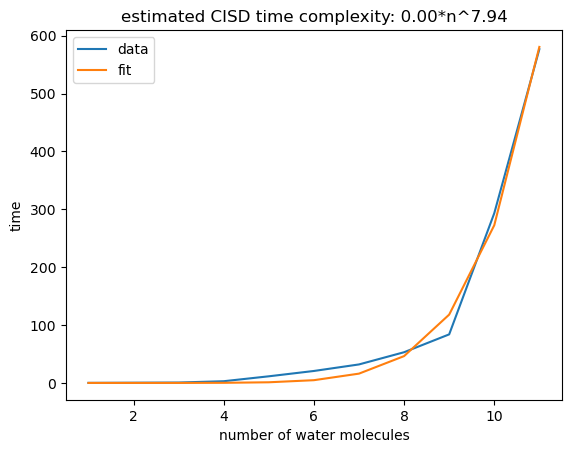

In [13]:
times, sizes = make_stats(cisd, 50, 300)
plot_comp(sizes, times, 'CISD', loglog=False)

converged SCF energy = -74.9645141153917
E(MP2) = -75.003380210593  E_corr = -0.0388660952013349
E(SCS-MP2) = -75.0091890382934  E_corr = -0.044674922901712
converged SCF energy = -149.928343866071
E(MP2) = -150.005072630664  E_corr = -0.0767287645929215
E(SCS-MP2) = -150.016579632399  E_corr = -0.0882357663279465
converged SCF energy = -224.884709399474
E(MP2) = -224.998395746774  E_corr = -0.113686347300578
E(SCS-MP2) = -225.015632509017  E_corr = -0.130923109542814
converged SCF energy = -299.846726354343
E(MP2) = -299.996062969219  E_corr = -0.149336614876224
E(SCS-MP2) = -300.018754894116  E_corr = -0.172028539773258
converged SCF energy = -374.80887406787
E(MP2) = -374.996547921951  E_corr = -0.187673854080967
E(SCS-MP2) = -375.025042366324  E_corr = -0.2161682984539
converged SCF energy = -449.768646393109
E(MP2) = -449.994201687514  E_corr = -0.225555294405345
E(SCS-MP2) = -450.028447308928  E_corr = -0.259800915819277
converged SCF energy = -524.730883491167
E(MP2) = -524.9937

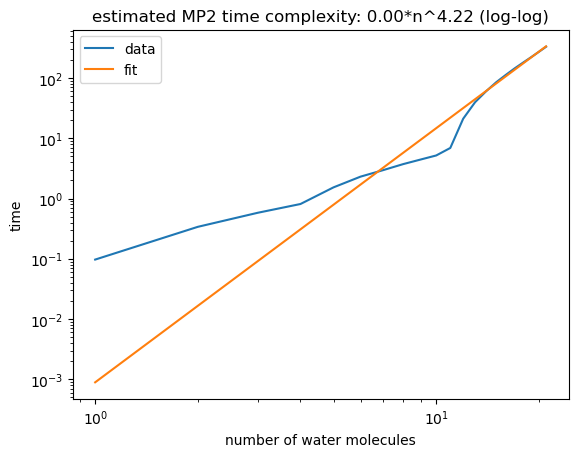

In [14]:
times, sizes = make_stats(mp2, 50, 300)
plot_comp(sizes, times, 'MP2')

## (d)
Each virion has a mass of about 1 fg = $10^{-15}$ g: https://www.pnas.org/doi/full/10.1073/pnas.2024815118

One carbon atom: $2 \cdot 10^{-26}$ g

$0.5 \cdot 10^{11}$ atoms per virion, 4 electrons per atom $\implies$ $2 \cdot 10^{11}$ electrons per virion $\implies t_f \approx 10^{22}s$

